# Introduction

This notebook provides a guide to using Xenium data and transferring cell type annotations from a reference dataset using spatial transcriptomics data tools. It demonstrates how to load, preprocess, and analyze multimodal imaging data, enabling exploration of spatially resolved cell types and their associated features.

The workflow includes downloading datasets, preparing spatial and reference data, applying dimensionality reduction techniques like PCA and UMAP, and transferring annotations. Visualization methods are showcased, including spatial plots with cell boundaries and phenotypic markers, focusing on specific regions and subsets of cell types.

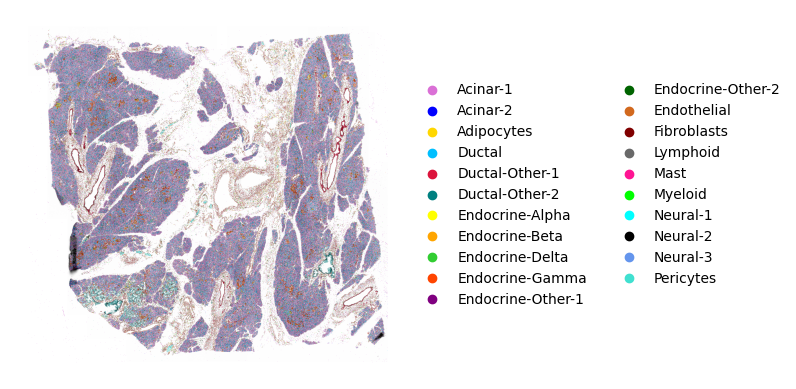

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist, squareform
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
import tifffile

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Transfer cell type annotation from one dataset to another



To get started, download two datasets (~3 GB and ~0.4 GB) from the provided Zenodo repository, then extract (unpack) 
the contents to a local directory on your machine. After unpacking, locate the variable named dataPath 
in the cell below and update its value to point to the folder where you extracted the data. Once you've 
set the correct path, you can run the subsequent cells to visualize 
and explore the multimodal imaging data.

In [ ]:
!curl -L "https://zenodo.org/api/records/15777497/files-archive" -o dataset.zip && unzip dataset.zip && rm dataset.zip

In [ ]:
!curl -L "https://zenodo.org/api/records/15777586/files-archive" -o dataset.zip && unzip dataset.zip && rm dataset.zip

In [ ]:
dataPath = ''

# Load the annotated reference dataset
adata = sc.read_h5ad(dataPath + 'x-subset-50k-all-umap-annotated.h5ad')

In [ ]:
# Palette for pancreas cell types
palette_pancreas_fine = {'Acinar-1': 'orchid', 'Acinar-2': 'blue',
                        'Ductal': 'deepskyblue', 'Ductal-Other-1': 'crimson', 'Ductal-Other-2': 'teal',
                        'Endocrine-Alpha': 'yellow', 'Endocrine-Beta': 'orange', 'Endocrine-Delta': 'limegreen', 'Endocrine-Gamma': 'orangered',
                        'Endocrine-Other-1': 'purple', 'Endocrine-Other-2': 'darkgreen',
                        'Endothelial': 'chocolate', 'Pericytes': 'turquoise', 'Fibroblasts': 'maroon', 'Adipocytes': 'gold',
                        'Lymphoid': 'dimgrey', 'Mast': 'deeppink', 'Myeloid': 'lime',
                        'Neural-1': 'cyan', 'Neural-2': 'black', 'Neural-3': 'cornflowerblue'}

In [ ]:
def load_xenium_dataset(id, path, N=None, suffix=None, f=1.):

    """Load a Xenium dataset from a specified Xenium bundle directory.

    Parameters
    ----------
    id : str
        Identifier for the sample (not used internally).
    path : str
        Path to the Xenium bundle directory. This directory should contain
        'cells.parquet' and 'cell_feature_matrix.h5' files.
    N : int, optional
        Number of cells to randomly sample. If None, use all cells.
    suffix : str, optional
        Suffix to append to cell indices.
    f : float, optional
        Scaling factor for spatial coordinates (default is 1.0).

    Returns
    -------
    adata : AnnData
        Data object with spatial coordinates in `adata.obsm['spatial']`.
    """

    obs = pd.read_parquet(path + '/cells.parquet', engine='auto', columns=None,
                          storage_options=None, use_nullable_dtypes=False).set_index('cell_id')
    adata = sc.read_10x_h5(path + '/cell_feature_matrix.h5')
    if not N is None:
        adata = adata[adata.obs.sample(N).index]
    adata.obs = obs.loc[adata.obs.index]
    if not suffix is None:
        adata.obs.index = adata.obs.index + suffix
    adata.obsm['spatial'] = (adata.obs[['x_centroid', 'y_centroid']]*f).astype(int).values

    return adata

def load_spatial_annotated(id, path, adata_ref, lowf=5, highf=10,
                        thumb_quantile=0.99, cell_diameter_fullres=7, mpp=0.2125):

    """Load a Xenium dataset and annotate it with spatial information and cell types.

    Parameters
    ----------
    id : str
        Identifier for the sample.

    path : str
        Path to the Xenium bundle directory. This directory should contain
        'cells.parquet', 'cell_feature_matrix.h5', and other relevant files.

    adata_ref : AnnData
        Reference AnnData object containing cell type annotations.

    lowf : int, optional
        Downsampling factor for low-resolution images (default is 5).

    highf : int, optional
        Downsampling factor for high-resolution images (default is 10).

    thumb_quantile : float, optional
        Quantile for thumbnail intensity scaling (default is 0.99).

    cell_diameter_fullres : int, optional
        Diameter of cells in full resolution (default is 7).

    mpp : float, optional
        Microns per pixel (default is 0.2125).
    """

    ad = load_xenium_dataset(id, path, suffix='.' + id)

    print('Loading PCA data...')
    with open(f'{path}/PCA-reference.pklz', 'rb') as tempfile:
        xgenes, tr_PCA = pickle.load(tempfile)
    ad.obsm['X_pca'] = tr_PCA.transform(ad[:, xgenes].X)

    print('Loading UMAP coordinates...')
    if True:
        # Load precomputed UMAP coordinates
        ad.obsm['X_umap'] = pd.read_parquet(f'{path}/UMAP.parquet', engine='auto', columns=None).loc[ad.obs.index].values
    else:
        # Use UMAP from reference could take under 1 hour
        # and the UMAP-reference.pklz is 7 GB, not shared
        with open(f'{path}/UMAP-reference.pklz', 'rb') as tempfile:
            tr_UMAP = pickle.load(tempfile)
        ad.obsm['X_umap'] = pd.DataFrame(index=ad.obs.index, data=tr_UMAP.transform(ad.obsm['X_pca'])).fillna(20.).values

    print('Log-transforming data...')
    sc.pp.log1p(ad)

    print('Loading thumbnail image data...')
    if True:
        # Load subsampled image
        thumbnail = tifffile.imread(f'{path}/thumbnail.tiff')
    else:
        # Load full image image
        imagef = f'{path}/morphology_focus/morphology_focus_0000.ome.tif'
        thumbnail = tifffile.imread(imagef)[::highf, ::highf]
        tifffile.imwrite(f'{path}/thumbnail.tiff', thumbnail)

    thumbnail = (255. * thumbnail / np.quantile(thumbnail.ravel(), thumb_quantile))
    thumbnail[thumbnail>255] = 255
    thumbnail = 255 - thumbnail
    thumbnail = (np.dstack([thumbnail]*3)).astype(np.uint8)

    print(f'Setting up spatial data for thunbnail {thumbnail.shape}...')
    ad.uns['spatial'] = {'library_id': {'images': {'hires': thumbnail,
                                        'lowres': thumbnail[::lowf, ::lowf]},
                        'scalefactors': {'tissue_hires_scalef': 1. / (mpp * highf),
                                        'tissue_lowres_scalef': 1. / (mpp * lowf * highf),
                                        'spot_diameter_fullres': cell_diameter_fullres}}}

    print('Loading mIF data...')
    codex = pd.read_parquet(f'{path}/mIF-cells.parquet', engine='auto', columns=None)
    codex = codex.drop(['centroid-0', 'centroid-1'], axis=1)
    codex.index = codex.index + '.' + id
    codex = codex.reindex(ad.obs.index).fillna(0.)
    ad.obs[codex.columns] = codex.values

    def annotate_sh(ind, df, df_ref):
        return pd.Series(index=ind, data=df_ref.index[cdist(df, df_ref, metric='correlation').argmin(axis=1)])

    print('Transferring cell type annotations...')
    identity = 'Celltype fine'
    df_sh_ref_fine = adata_ref.to_df()
    df_sh_ref_fine.index = adata.obs[identity].reset_index(drop=True).values
    df_sh_ref_fine = df_sh_ref_fine.groupby(level=0).mean()

    ad.obs[identity] = annotate_sh(ad.obs.index, ad.to_df(), df_sh_ref_fine)

    ad.uns['df_cell_boundaries'] = pd.read_parquet(f'{path}/cell_boundaries.parquet')

    return ad

def plotWithBoundaries(ad, x1, x2, y1, y2, var=None, dfb=None, palette='tab20',
                    figsize=(7, 7), colormap={}, colormap2='viridis', s='', exclusion='',
                    vmin=None, vmax=None, qmin=None, qmax=None, title=''):

    """Plot cell boundaries with color coding based on a specified variable.

    Parameters
    ----------
    ad : AnnData
        Annotated data object containing spatial coordinates and cell type annotations.

    x1, x2, y1, y2 : float
        Coordinates defining the region of interest to plot.

    var : str, optional
        Variable to use for color coding the cell boundaries.

    dfb : pd.DataFrame, optional
        DataFrame containing cell boundary information. If None, it will be loaded from `ad.uns['df_cell_boundaries']`.
    
    palette : str, optional
        Name of the color palette to use for cell types (default is 'tab20').

    figsize : tuple, optional
        Size of the figure to create (default is (7, 7)).

    colormap : dict, optional
        Custom colormap for cell types. If provided, it will override the default palette.

    colormap2 : str, optional
        Name of the colormap to use for continuous variables (default is 'viridis').

    s : str, optional
        Suffix to append to cell indices in the DataFrame (default is '').

    exclusion : str, optional
        String to exclude from the labels (default is '').

    vmin, vmax : float, optional
        Minimum and maximum values for color scaling. If None, they will be determined from the data.

    qmin, qmax : float, optional
        Quantiles to use for determining vmin and vmax. If both are None, the full range of the variable will be used.

    title : str, optional
        Title of the plot (default is an empty string).
    """
    colormap_ = colormap.copy()

    if var in ad.obs:
        se = ad.obs[var]
    elif var in ad.var.index:
        se = ad[:, var].to_df()[var]
    else:
        raise ValueError(f'Variable {var} not found in adata.obs or adata.var.index')

    if (se.dtype == 'category') or (se.dtype == bool) or (se.dtype == str) or (se.dtype == 'O'):
        se_max = None
    else:
        se_max = se.max()

    if not qmin is None and not qmax is None:
        vmin = se.quantile(qmin)
        vmax = se.quantile(qmax)

    def calculate_legend_columns(num_items, max_height, item_height):
        max_items_per_column = max_height // item_height
        num_columns = (num_items + max_items_per_column - 1) // max_items_per_column
        return num_columns

    dfb_sub = dfb[(dfb['vertex_x']>=x1) & (dfb['vertex_x']<=x2) & (dfb['vertex_y']>=y1) & (dfb['vertex_y']<=y2)]

    gb = dfb_sub[['cell_id', 'vertex_x', 'vertex_y']].groupby('cell_id').agg(list)
    dgb = {}
    for c in gb.index:
        v = gb.loc[c].values
        v = np.vstack([np.array(v[0]), np.array(v[1])]).T
        dgb[c] = v
    print(f'Found {len(dgb)} cell boundaries in the specified region.')

    backup_palette = plt.get_cmap(palette)
    N_colors = backup_palette.N
    used_color_index = 0

    patches = []
    keys = list(dgb.keys())
    colors = {}
    labels = {}
    ucolors = {}
    for c in keys:
        if c + '.' + s in se.index:
            if se_max is None:
                celltype = se.loc[c + '.' + s]
                if not celltype in colormap_:
                    colormap_[celltype] = backup_palette(used_color_index % N_colors)
                    used_color_index += 1
                colors[c] = colormap_[celltype]
                labels[c] = celltype
                if celltype not in ucolors:
                    ucolors[celltype] = colors[c]

    for c in keys:
        if c + '.' + s in se.index:
            v = dgb[c]
            if se_max is None:
                patches.append(Polygon(v, closed=True, fill=True,
                                    edgecolor='k' if not exclusion in labels[c] else colors[c],
                                    linewidth=0.5, facecolor=colors[c], label=labels[c]))
            else:
                cmap = plt.get_cmap(colormap2, 256)
                vc = se.loc[c + '.' + s]
                if vmin is not None and vmax is not None:
                    vc = (vc - vmin) / (vmax - vmin)
                    vc = np.clip(vc, 0, 1)
                patchcolor = cmap(vc)
                patches.append(Polygon(v, closed=True, fill=True,
                                    edgecolor='k' if not exclusion=='' else patchcolor,
                                    linewidth=0.5, facecolor=patchcolor, label=None))

    unique_patches = {patch.get_label(): patch for patch in patches}.values()

    fig, ax = plt.subplots(figsize=figsize)
    pc = PatchCollection(patches, match_original=True)
    ax.add_collection(pc)
    ax.set_xlim(x1, x2)
    ax.set_ylim(y2, y1)
    ax.set_xlabel('X Coordinate, µm', fontsize=14)
    ax.set_ylabel('Y Coordinate, µm', fontsize=14)
    ax.set_aspect('equal')
    plt.title(title, fontsize=16)

    if se_max is None:
        max_height = fig.get_figheight() * fig.dpi
        item_height = 25
        num_columns = calculate_legend_columns(len(unique_patches), max_height, item_height)

        cic_handles = []
        mkeys = sorted(list(ucolors.keys()), key=str.lower)
        for celltype in mkeys:
            color = ucolors[celltype]
            cic_handles.append(Line2D([0], [0], marker='o', color='w', label=celltype, markerfacecolor=color, markersize=12))
        ax.legend(handles=cic_handles, bbox_to_anchor=(1, 0.5), loc='center left', ncol=num_columns, fancybox=False,
                frameon=False, fontsize=12, title='', title_fontsize=16)
    else:
        pc.set_cmap(colormap2)
        pc.set_clim(vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(pc, ax=ax, label=var, orientation='vertical', fraction=0.03, pad=0.04)
        cbar.ax.set_ylabel(var, fontsize=14)
        cbar.ax.tick_params(labelsize=12)

    plt.show()

    return

In [ ]:
id = 'JDC-WP-012-w'
dataPath = ''

# Load the spatial annotated dataset example, containing all cells for the specified ID
ad = load_spatial_annotated(id, dataPath, adata)

## Variables to explore

**Genes**:
ABCC8, ACKR1, ACKR3, ACSL1, ACTA2, ADCYAP1, ADIPOQ, ALDH1A1, AMY2A, ANKRD33B, AQP1, AQP8, ARX, ASCL1, AURKA, BARX2, BAX, BCL2, BCL2L1, BCL2L2, BUB1, C11orf96, C1QA, C3, CALCA, CALCB, CALD1, CARTPT, CASR, CAVIN1, CCL2, CCL5, CCNB2, CCND1, CCNE2, CCNL2, CCR2, CD2, CD274, CD3D, CD3E, CD3G, CD52, CD55, CD63, CD68, CD7, CD74, CD84, CD8A, CD9, CD96, CDC20, CDH19, CDK1, CDK5RAP3, CDKN1A, CDKN1C, CDKN2A, CDX2, CEACAM6, CFTR, CHGA, CHGB, CHRM3, CLDN18, CLU, CMTM8, COL1A1, COL1A2, COL6A2, COMP, CORT, CPA3, CREB5, CRHR2, CSF1R, CTNNB1, CTRB1, CTSB, CTSK, CXCL1, CXCL12, CXCL2, CXCL6, CXCL8, CXCR4, DDX60L, DLK1, DPT, E2F1, ENO1, ERO1B, ERP27, ESAM, ETV1, FABP4, FAP, FDXR, FFAR3, FFAR4, FOLR1, FOSB, FOXB1, FOXB2, FOXO1, FOXP3, FRZB, G6PC2, GABRA6, GAL, GATM, GC, GCG, GCGR, GCNT3, GDF15, GEM, GHRL, GHSR, GLIS3, GLP1R, GLS, GPM6B, GPNMB, GPX3, GSDMB, GSDMD, GSDME, GSN, GZMK, HADH, HES1, HES4, HHEX, HLA-E, HNF1B, HPGDS, HSF4, HSPB1, IAPP, IFNG, IGFBP7, IGHD, IGHG1, IGHM, IL1RL1, IL2RB, IL32, INS, IRX2, ISL1, JUN, JUND, KIT, KLRC1, KLRG1, KRAS, KRT19, KRT7, KRT8, L1CAM, LCN2, LENG8, LEPR, LGALS1, LGI4, LGMN, LOXL4, LPL, LRFN5, LYZ, MAFA, MALL, MAP1B, MCM6, MDM2, MEIS2, MLXIPL, MMP7, MRC1, MS4A8, MT1A, MUC13, MUC5AC, MUC5B, MYC, NAP1L4, NEUROG1, NEUROG3, NKX2-2, NKX6-1, NPTX2, NPY, NPY1R, NR5A2, NUSAP1, ONECUT1, OPN4, PCNA, PDGFRA, PDGFRB, PDPN, PDX1, PECAM1, PGC, PGF, PHGR1, PHIP, PHLDA3, PLIN2, PLK3, PLXNB2, POLD3, PPP1R1B, PPY, PRDX1, PRG4, PROX1, PRSS1, PTF1A, PYY, RB1, RBP4, RBPJL, RGS5, S100A11, S100A6, SAMSN1, SCNN1G, SCTR, SDC1, SDS, SERPINA1, SERPINE1, SERPINH1, SERPINI2, SIGLEC6, SIX2, SIX3, SLC22A6, SLC30A8, SLC6A4, SLC6A6, SLC7A2, SLC7A8, SNRNP70, SORL1, SOX10, SOX4, SOX9, SPARC, SPATA2L, SPHK1, SPIC, SPINK1, SPINT2, SQSTM1, SSR1, SST, SSTR1, SSTR2, STMN2, STX1A, SULT1C2, SYCN, SYT13, TAC1, TAGLN, TEN1, TFF1, TFF2, TGFB1I1, TGFBR2, TIMP1, TM4SF1, TM4SF4, TMSB10, TNFRSF10B, TNFRSF12A, TNFRSF1A, TP53, TRIAP1, TSPAN1, TSPAN8, TTR, TUBGCP2, TXNIP, UBALD2, UCHL1, UCP1, VEGFA, VGF, VIM, VIP, VWA5A, XCL1, YBX3, ZBTB7A, ZMAT3

In addition to the 300 genes the data contains cell type annotation (**Celltype fine**), number of transcripts per cell (**total_counts**), cell size (**cell_area**), <br>
and 39 channels of **PhenoCycler** data (a.k.a., CODEX): <br>
DAPI, CD45RA, S100B, <br>
Insulin, Carbonic Anhydrase 9, Vimentin, <br>
Glucagon, CD45RO, Collagen I, p21, <br>
MPO, MECOM, CFTR, PGP9.5, <br>
Keratin 19, 53BP1, p16, Cadherin 11, <br>
Somatostatin, CD8, Lamin B1, CD3e, <br>
C-Peptide, HMGB1, Perilipin, Podoplanin, <br>
Pancreatic Polypeptide, CD4, E-cadherin, <br>
CD31, CD68, Ki67, EpCAM, CD45, <br>
CD56, CD20, FOXP3, gH2AX, SMA.

In [ ]:
# Spatial plot without boundaries, cells are shown as dots colored by cell type
sc.pl.spatial(ad, color=['Celltype fine'], frameon=False, size=1, palette=palette_pancreas_fine, title='')

## Subset by spatial location and visualize

In [ ]:
x1, y1 = 2000, 7500
dx, dy = 1000, 1000

plotWithBoundaries(ad, x1, x1 + dx, y1, y1 + dy, s=id, var='Celltype fine', exclusion='NA', dfb=ad.uns['df_cell_boundaries'], colormap=palette_pancreas_fine, figsize=(6, 6))
plotWithBoundaries(ad, x1, x1 + dx, y1, y1 + dy, s=id, var='CODEX-p16', exclusion='NA', dfb=ad.uns['df_cell_boundaries'], figsize=(6, 6), qmin=0.005, qmax=0.995, colormap2='hot_r')
plotWithBoundaries(ad, x1, x1 + dx, y1, y1 + dy, s=id, var='MUC5AC', exclusion='NA', dfb=ad.uns['df_cell_boundaries'], figsize=(6, 6), qmin=0.005, qmax=0.995)
plotWithBoundaries(ad, x1, x1 + dx, y1, y1 + dy, s=id, var='MUC5B', exclusion='NA', dfb=ad.uns['df_cell_boundaries'], figsize=(6, 6), qmin=0.005, qmax=0.995)
plotWithBoundaries(ad, x1, x1 + dx, y1, y1 + dy, s=id, var='CODEX-Carbonic Anhydrase 9', exclusion='NA', dfb=ad.uns['df_cell_boundaries'], figsize=(6, 6), qmin=0.005, qmax=0.995)

## Region of interest shows cells highly expressing protein p16 and acinar cell identity

In [ ]:
x1, y1 = 2250, 7650
dx, dy = 250, 150

plotWithBoundaries(ad, x1, x1 + dx, y1, y1 + dy, s=id, var='Celltype fine', exclusion='NA', dfb=ad.uns['df_cell_boundaries'], colormap=palette_pancreas_fine, figsize=(4, 4))
plotWithBoundaries(ad, x1, x1 + dx, y1, y1 + dy, s=id, var='CODEX-p16', exclusion='NA', dfb=ad.uns['df_cell_boundaries'], figsize=(4, 4), qmin=0.005, qmax=0.995, colormap2='hot_r')

## Region of interest shows cells highly expressing protein p16 and Ductal-Other-2 identity

In [ ]:
x1, y1 = 2500, 8200
dx, dy = 300, 300

plotWithBoundaries(ad, x1, x1 + dx, y1, y1 + dy, s=id, var='Celltype fine', exclusion='NA', dfb=ad.uns['df_cell_boundaries'], colormap=palette_pancreas_fine, figsize=(4, 4))
plotWithBoundaries(ad, x1, x1 + dx, y1, y1 + dy, s=id, var='CODEX-p16', exclusion='NA', dfb=ad.uns['df_cell_boundaries'], figsize=(4, 4), qmin=0.005, qmax=0.995, colormap2='hot_r')

## Subsetting cell types helps to focus on specific cell types of interest

In [ ]:
groups = ['Ductal', 'Ductal-Other-1', 'Ductal-Other-2']

wh = ad.obs['Celltype fine'].isin(groups)

x1, y1 = 2000, 7500
dx, dy = 1000, 1000
plotWithBoundaries(ad[wh], x1, x1 + dx, y1, y1 + dy, s=id, var='Celltype fine', exclusion='NA', dfb=ad.uns['df_cell_boundaries'], colormap=palette_pancreas_fine, figsize=(6, 6))

## Large region can be displayed, cell boundaries are not shown for clarity

In [ ]:
groups = ['Acinar-1', 'Acinar-2', 'Ductal', 'Ductal-Other-1', 'Ductal-Other-2',
        'Endocrine-Alpha', 'Endocrine-Beta', 'Endocrine-Delta', 'Endocrine-Gamma',
        'Endocrine-Other-1', 'Endocrine-Other-2']

wh = ad.obs['Celltype fine'].isin(groups)

x1, y1 = 1500, 5000
dx, dy = 2000, 2000
plotWithBoundaries(ad[wh], x1, x1 + dx, y1, y1 + dy, s=id, var='Celltype fine', exclusion='', dfb=ad.uns['df_cell_boundaries'], colormap=palette_pancreas_fine, figsize=(6, 6))

## Alternative approach to plot cells without boundaries, using scanpy's spatial plotting

In [ ]:
x1, y1 = 2500, 8200
dx, dy = 300, 300

plt.rcParams["figure.figsize"] = (5, 5)
wh = (ad.obs['x_centroid'] >= x1) & (ad.obs['x_centroid'] <= x1 + dx) & (ad.obs['y_centroid'] >= y1) & (ad.obs['y_centroid'] <= y1 + dy)
sc.pl.spatial(ad[wh].copy(), color=['Celltype fine'], palette=palette_pancreas_fine, title='')

In [ ]:
x1, y1 = 8400, 1200
dx, dy = 700, 600

plt.rcParams["figure.figsize"] = (5, 5)
wh = (ad.obs['x_centroid'] >= x1) & (ad.obs['x_centroid'] <= x1 + dx) & (ad.obs['y_centroid'] >= y1) & (ad.obs['y_centroid'] <= y1 + dy)
sc.pl.spatial(ad[wh].copy(), color=['Celltype fine'], palette=palette_pancreas_fine, title='')

In [ ]:
groups = ['Acinar-1', 'Acinar-2', 'Ductal', 'Ductal-Other-1', 'Ductal-Other-2',
        'Endocrine-Alpha', 'Endocrine-Beta', 'Endocrine-Delta', 'Endocrine-Gamma',
        'Endocrine-Other-1', 'Endocrine-Other-2']

x1, y1 = 1500, 5000
dx, dy = 2000, 2000

plt.rcParams["figure.figsize"] = (6, 6)
wh = (ad.obs['x_centroid'] >= x1) & (ad.obs['x_centroid'] <= x1 + dx) & (ad.obs['y_centroid'] >= y1) & (ad.obs['y_centroid'] <= y1 + dy)
sc.pl.spatial(ad[wh].copy(), color=['Celltype fine'], groups=groups, palette=palette_pancreas_fine, title='')